In [ ]:
# mount drive https://datascience.stackexchange.com/questions/29480/uploading-images-folder-from-my-system-into-google-colab
# login with your google account and type authorization code to mount on your google drive.
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install efficientnet_pytorch

In [ ]:
## 학습 코드
import numpy as np
import json
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms, utils
from skimage import io, transform
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from efficientnet_pytorch import EfficientNet
from torch.optim.lr_scheduler import StepLR
from sklearn import metrics
import gc
from sklearn.metrics import roc_auc_score

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
#############################################
# Mydataset class reads csvfile.
# This csvfile contains train image id and it's additional info of the patient(metadata). 
# Then it crops the image id and its metadata.
# Image is loaded by this id.
# The metadata is converted into the concatanated one-hot-vector in here.
# We used 3 kinds of metadata; sex, age, and symptom position.
#############################################

class Mydataset(Dataset):
    def __init__(self,csvfile,root_dir,transform=None):
        self.landmarks_frame=pd.read_csv(csvfile)
        self.root_dir=root_dir
        self.transform=transform
        self.diagnose_dict = {"melanoma": 0, "nevus": 1}

    def __len__(self):
        return len(self.landmarks_frame)

    def one_hot_sex(self, sex):
        if sex == "male":
            return [1, 0]
        else:
            return [0, 1]

    def one_hot_age(self, age):
        arr = [0] * 10
        arr[int(age/10)] = 1
        return arr

    def one_hot_site(self, site):
        if site == "head/neck":
            return [1, 0, 0, 0, 0, 0]
        elif site == "upper extremity":
            return [0, 1, 0, 0, 0, 0]
        elif site == "lower extremity":
            return [0, 0, 1, 0, 0, 0]
        elif site == "torso":
            return [0, 0, 0, 1, 0, 0]
        elif site == "palms/soles":
            return [0, 0, 0, 0, 1, 0]
        elif site == "oral/genital":
            return [0, 0, 0, 0, 0, 1]
        else: assert(0)

    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name=os.path.join(self.root_dir,self.landmarks_frame.iloc[idx, 0])  #Construct the image path from the given id
        image = io.imread(img_name+".jpg")                                      #Load the image from that path
        image = transforms.ToTensor()(image)
        if self.transform:
            image = self.transform(image)

        try:
            diagnose = self.diagnose_dict[self.landmarks_frame.iloc[idx, 5]]
        except:
            diagnose = 1

        sex = self.landmarks_frame.iloc[idx, 2]
        sex = self.one_hot_sex(sex)
        
        age = self.landmarks_frame.iloc[idx, 3]
        age = self.one_hot_age(age)

        site = self.landmarks_frame.iloc[idx, 4]
        site = self.one_hot_site(site)

        metadata = np.array(sex + age + site).astype(np.float32)                #Concat all metadatas and make a 1*(2+10+6)=1*18 tensor
        metadata = torch.from_numpy(metadata)

        image = image.to(device)
        metadata = metadata.to(device)
        diagnose = torch.tensor(diagnose, dtype=torch.long)
        diagnose = diagnose.to(device)
        
        sample = {'image': image, 'metadata': metadata, 'diagnose': diagnose}

        return sample

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224))
    ])

train_dataset = Mydataset(csvfile='/content/drive/My Drive/2020Fall/인공개 팀플/jpeg-melanoma-256x256/csv/train_no_unknown.csv',root_dir='/content/drive/My Drive/2020Fall/인공개 팀플/jpeg-melanoma-256x256/train',transform=train_transform)
train_set, val_set = torch.utils.data.random_split(train_dataset, [5000, 622])
train_dataloader = DataLoader(train_set, batch_size=64, shuffle=True, drop_last=True)
validation_dataloader = DataLoader(val_set, batch_size=16, shuffle=True, drop_last=True)


5622


In [ ]:
#############################################
# Actual framework of our model architecture.
#############################################

class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        # if (baseline_model == "")
        cnn_model_name = 'efficientnet-b0'
        self.cnn_model = EfficientNet.from_pretrained(cnn_model_name, num_classes=2).to(device)
        print(EfficientNet.get_image_size(cnn_model_name))
        self.cnn = nn.Sequential (                                               #EfficientNet layer for image
            nn.Linear(1280, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
        )

        self.meta = nn.Sequential (                                              #MLP layer for metadata 
            nn.Linear(18, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
        ) 

        self.post = nn.Sequential (                                              #Post-process layer 
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(32, 2)
        )

        ################################

    def forward(self, image, metadata):
        image = self.cnn_model.extract_features(image)
        
        image = nn.AdaptiveAvgPool2d(output_size=(1, 1))(image)
        image = torch.squeeze(image, -1)
        image = torch.squeeze(image, -1)
        img_out = self.cnn(image)                                               # EffieicntNet extracts features from image.
        meta_out = self.meta(metadata)                                          # Metadatas are feed into MLP layer.
        output = self.post(torch.cat((img_out, meta_out), dim = 1))             # Concat 2 outputs, and post-process to convert the output dimension into 2(nevus/melanoma).
        #######################################################################
        return output

In [ ]:
model = MyNetwork().to(device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
gc.collect()

Loaded pretrained weights for efficientnet-b0
224
4247968


시작
epoch: 0 / training_loss : 0.597
epoch: 0 / training_accuracy : 0.694
epoch: 0 / validation_loss : 0.563
epoch: 0 / validation_accuracy : 0.878
68.2501482963562
epoch: 1 / training_loss : 0.489
epoch: 1 / training_accuracy : 0.826
epoch: 1 / validation_loss : 1.101
epoch: 1 / validation_accuracy : 0.579
67.76284503936768
epoch: 2 / training_loss : 0.410
epoch: 2 / training_accuracy : 0.899
epoch: 2 / validation_loss : 1.889
epoch: 2 / validation_accuracy : 0.431
68.22064399719238
epoch: 3 / training_loss : 0.356
epoch: 3 / training_accuracy : 0.929
epoch: 3 / validation_loss : 1.259
epoch: 3 / validation_accuracy : 0.653
67.22654151916504
epoch: 4 / training_loss : 0.311
epoch: 4 / training_accuracy : 0.949
epoch: 4 / validation_loss : 0.681
epoch: 4 / validation_accuracy : 0.854
67.37317991256714
epoch: 5 / training_loss : 0.284
epoch: 5 / training_accuracy : 0.950
epoch: 5 / validation_loss : 0.394
epoch: 5 / validation_accuracy : 0.914
67.41486167907715
epoch: 6 / training_loss :

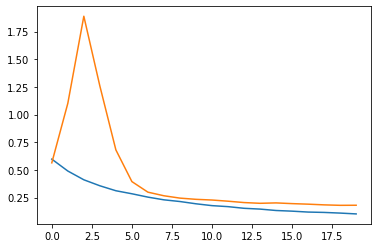

In [ ]:
#############################################
# Training code.
#############################################
learning_rate = 0.0001
epoch = 20
training_loss = 0
train_loss_list=[]
validation_loss_list=[]
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.001)
scheduler = StepLR(optimizer, step_size=1, gamma=0.95)                          #Learning rate decay to find optimal better
print("시작")
for ep in range(epoch):                                                         #Training process.
    training_loss = 0
    training_accuracy = 0
    train_num_data = 0
    model.train()
    st=time.time()
    for batch_idx, dictionary in enumerate(train_dataloader):
        x = dictionary['image']                                                 #  Send `x` and `y` to either cpu or gpu using `device` variable.
        y = dictionary['diagnose']
        meta = dictionary['metadata']

        logit = model(x, meta)                                                  # Feed `x` into the network, get an output, and keep it in a variable called `logit`. 

        accuracy = (logit.argmax(dim=1) == y).float().mean()                    # Compute accuracy of this batch using `logit`, and keep it in a variable called 'accuracy'.
        loss = nn.CrossEntropyLoss()(logit, y)                                  # Compute loss using `logit` and `y`, and keep it in a variable called `loss`.
        optimizer.zero_grad()
        loss.backward()                                                         # backward the computed loss. 
        optimizer.step()                                                        # update the network weights. 
        training_loss += loss.item()*x.shape[0]
        training_accuracy += accuracy.item()*x.shape[0]
        train_num_data += x.shape[0]

    scheduler.step()
    training_loss /= train_num_data
    training_accuracy /= train_num_data
    print(f'epoch: {ep} / training_loss : {training_loss:.3f}')
    print(f'epoch: {ep} / training_accuracy : {training_accuracy:.3f}')
    train_loss_list.append(training_loss)
    
    model.eval()                                                                #Validation process. It's very similar to the training part, but not calculating gradient.
    with torch.no_grad():
        validation_loss = 0.
        validation_accuracy = 0.
        validation_num_data = 0.
        for batch_idx, dictionary in enumerate(validation_dataloader):
            x = dictionary['image']
            y = dictionary['diagnose']
            meta = dictionary['metadata']

            logit = model(x, meta)
            loss = nn.CrossEntropyLoss()(logit, y)

            accuracy = (logit.argmax(dim=1) == y).float().mean()

            validation_loss += loss.item()*x.shape[0]
            validation_accuracy += accuracy.item()*x.shape[0]
            validation_num_data += x.shape[0]

        validation_loss /= validation_num_data
        validation_accuracy /= validation_num_data
        validation_loss_list.append(validation_loss)
        print(f'epoch: {ep} / validation_loss : {validation_loss:.3f}')
        print(f'epoch: {ep} / validation_accuracy : {validation_accuracy:.3f}')
        print(time.time()-st)

plt.plot(np.arange(epoch),np.array(train_loss_list))
plt.plot(np.arange(epoch),np.array(validation_loss_list))

In [ ]:
torch.save(model.state_dict(), f'/content/drive/My Drive/2020Fall/인공개 팀플/results/efficient_b1_model_final_20ep.pt')
print("model saved")

model saved
